**Team ID**: 102
    
**Members Name**
* Hailin Du, hailind2@illinois.edu
* Bo Hu, bo12@illinois.edu
* Haonan Shi, haonans4@illinois.edu

**Project Draft**:
BEHRT: Transformer for Electronic Health Records

**Github Repo Link**:
BEHRT: Transformer for Electronic Health Records

**Input Data Link**:
https://drive.google.com/drive/folders/1Z68xodU6IqusYJbRINw929CQ6ilOyneo?usp=sharing

**Introduction**

The original paper (BEHRT: Transformer for Electronic Health Records) introduces a deep neural sequence transduction model designed specifically for electronic health records (EHR). BEHRT from the paper stands for BERT (Bidirectional Encoder Representations from Transformers) for EHR, which is capable of simultaneously predicting the likelihood of 301 medical conditions across future patient visits. The paper uses data from the Clinical Practice Research Datalink (CPRD), which includes records from 674 general practitioner (GP) practices in the UK. This database combines primary care data with hospital records and other health-related information, covering about 7% of the UK population, or 35 million patients.BEHRT's approach to predicting medical conditions based on patient visit sequences offers better diagnostics and personalized treatment plans.

To fully replicate the study, we would need access to the Clinical Practice Research Datalink (CPRD) dataset, which is currently not feasible. Instead, we are using the MIMIC-III database, which includes detailed records from over forty thousand patients who were admitted to the critical care units of Beth Israel Deaconess Medical Center between 2001 and 2012. Given the differences in data structure between MIMIC-III and CPRD, a direct replication of the original study is not currently possible. Initially, we have focused on building a baseline model to establish a foundation before fully exploring the BERT architecture. This preliminary model includes layers such as LSTM, embedding, dropout, and dense.

**Scope of Reproducibility**

Firstly, our initial focus will be on analyzing the MIMIC-III dataset using a baseline model before delving into the architecture and structure of BERT. We have tried to understand the data preprocessing and model structure. However, due to differing data formats, we are limited in fully adopting the core concept from the original paper, which involves using patient visit sequences (including measurements, diagnoses, and medications) to predict subsequent visits. Our approach will adapt these concepts as closely as possible within the constraints held by the different data formats and structures of the MIMIC-III dataset. We will explore multiple approaches to identify useful inputs and define label classifications for predictions, focusing to assess how well our model performs in comparison to the original paper.

**Methodology**

We are constructing a baseline model using a combination of LSTM, embedding, dropout, and dense layers to process sequences of patient visits and predict subsequent medical events, such as diagnoses. This approach forms the foundation for understanding the potential benefits of more complex architectures like BERT later on.

In [ ]:
# import packages
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, AUC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout

**Data - Exploratory Data Analysis (EDA)**

We will be using the MIMIC-III dataset, a full relational database containing detailed medical information about patient stays in the Beth Israel Deaconess Medical Center. This dataset includes 26 interconnected tables, which contains data on patient demographics, hospital admissions, intensive care unit stays, and more, linked through unique identifiers such as SUBJECT_ID, HADM_ID, and ICUSTAY_ID.

We are uses the MIMIC-III dataset, consists of 6.2 GB across 26 tables in CSV format. For our specific analysis, we will focus on four key tables: PATIENTS, ADMISSIONS, DIAGNOSES_ICD, and D_ICD_DIAGNOSES.

* `PATIENTS`: This table contains demographic information about each patient, such as age, gender, and ethnicity, providing essential background for each subject in the study.
* `ADMISSIONS`: This table details each patient's hospital visits, capturing data on admission and discharge times, the type of admission, and the source of admission, which are critical for tracking patient trajectories through the healthcare system.
* `DIAGNOSES_ICD`: Here, each entry corresponds to a diagnosis assigned during hospital stays, coded using the ICD-9 standard. This table is linked to specific admissions and patients, offering a rich dataset of medical diagnoses.
* `D_ICD_DIAGNOSES`: This dictionary table provides full descriptions for each ICD-9 code listed in DIAGNOSES_ICD, enabling a clearer understanding of the medical conditions associated with the codes.

By focusing on these specific tables, we try to integrate demographic data, hospital visit records, and detailed diagnostic codes to study patterns and outcomes in patient health. This approach allows us to replicate the core idea of the original paper, which involves using patient visit sequences to predict the next visits.

In [ ]:
# define path
path = 'D:/df/'
patients = pd.read_csv(f'{path}PATIENTS.csv')
admissions = pd.read_csv(f'{path}ADMISSIONS.csv')
diagnoses_icd = pd.read_csv(f'{path}DIAGNOSES_ICD.csv')
d_icd_diagnoses = pd.read_csv(f'{path}D_ICD_DIAGNOSES.csv')

# reading data
df = admissions.merge(patients, on='SUBJECT_ID', suffixes=('', '_pat'))
df = df.merge(diagnoses_icd, on=['SUBJECT_ID', 'HADM_ID'], suffixes=('', '_diag'))
df = df.merge(d_icd_diagnoses, on='ICD9_CODE', suffixes=('', '_icd'))

df.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ROW_ID_diag,SEQ_NUM,ICD9_CODE,ROW_ID_icd,SHORT_TITLE,LONG_TITLE
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,NaN,NaN,0,151,1.0,9678,11344,Pois-sedative/hypnot NEC,Poisoning by other sedatives and hypnotics
1,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,NaN,NaN,0,152,2.0,9693,11553,Poison-antipsychotic NEC,"Poisoning by other antipsychotics, neuroleptic..."
2,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,NaN,NaN,0,153,3.0,E9502,9947,Poison-sedat/hypnotic,Suicide and self-inflicted poisoning by other ...
3,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,NaN,NaN,0,154,4.0,E9503,9948,Poison-psychotropic agt,Suicide and self-inflicted poisoning by tranqu...
4,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,NaN,NaN,NaN,0,156,6.0,29620,3337,Depress psychosis-unspec,"Major depressive affective disorder, single ep..."


In [ ]:
# dropping insignificant cols
columns_to_drop = ['ROW_ID', 'ROW_ID_pat', 'ROW_ID_diag', 'ROW_ID_icd',
                   'DOD', 'DOD_HOSP', 'DOD_SSN', 'EDREGTIME', 'EDOUTTIME', 'HADM_ID']
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [ ]:
# creating additional cols

# adding age col
def age_to_df(df):
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME']).dt.date
    df['DOB'] = pd.to_datetime(df['DOB']).dt.date

    df['AGE_AT_ADMIT'] = df.apply(lambda row: (row['ADMITTIME'] - row['DOB']).days // 365, axis=1)

    return df

# adding hospital stays
def length_of_stay(df):
    df['ADMITTIME'] = pd.to_datetime(df['ADMITTIME']).dt.date
    df['DISCHTIME'] = pd.to_datetime(df['DISCHTIME']).dt.date

    df['LENGTH_OF_STAY'] = df.apply(lambda row: max(0, (row['DISCHTIME'] - row['ADMITTIME']).days), axis=1)

    return df

In [ ]:
# apply the transformation
df = age_to_df(df)
df = length_of_stay(df)

In [ ]:
# sort the patient visit
df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'], inplace=True)
df_filter = df.groupby('SUBJECT_ID').filter(lambda x: len(x) >= 8)


---------Length of Dataset ---------
MIMIC-III: 554795

---------Age Statistics---------
count    554795.000000
mean         76.251453
std          58.829731
min           0.000000
25%          54.000000
50%          67.000000
75%          79.000000
max         311.000000
Name: AGE_AT_ADMIT, dtype: float64

---------Length_of_Stay Statistics---------
count    554795.000000
mean         13.118574
std          14.821515
min           0.000000
25%           5.000000
50%           9.000000
75%          16.000000
max         295.000000
Name: LENGTH_OF_STAY, dtype: float64


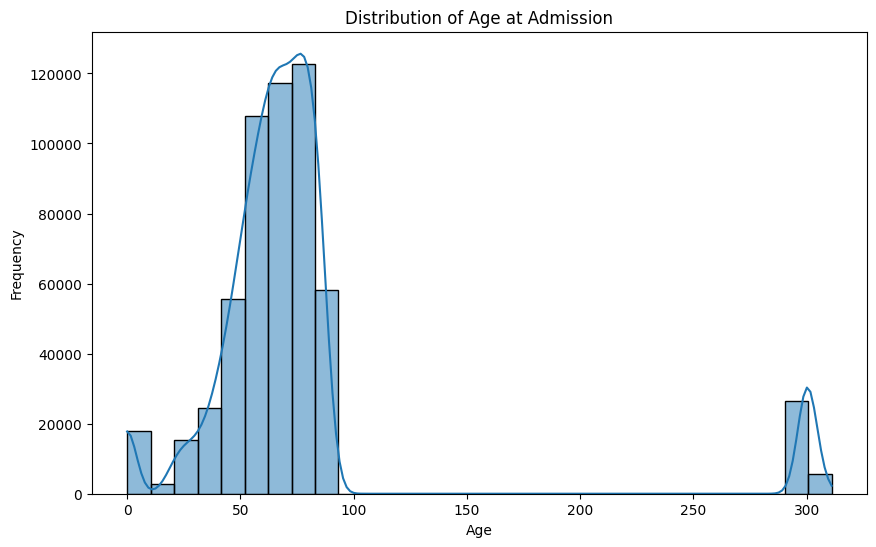

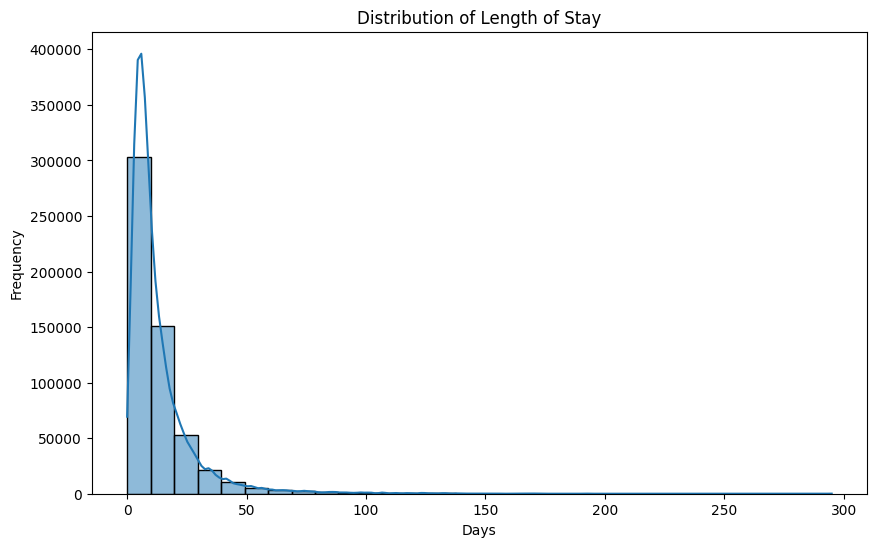

In [ ]:
# dataset info
print('\n---------Length of Dataset ---------')
print('MIMIC-III: ' + str(len(df_filter)))

# age statistics
print('\n---------Age Statistics---------')
print(df_filter['AGE_AT_ADMIT'].describe())

# length of stay statistics
print('\n---------Length_of_Stay Statistics---------')
print(df_filter['LENGTH_OF_STAY'].describe())

# histogram for age at admit
plt.figure(figsize=(10, 6))
sns.histplot(df_filter['AGE_AT_ADMIT'], bins=30, kde=True)
plt.title('Distribution of Age at Admission')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# histogram for length of stay
plt.figure(figsize=(10, 6))
sns.histplot(df_filter['LENGTH_OF_STAY'], bins=30, kde=True)
plt.title('Distribution of Length of Stay')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()


---------Admission Type Statistics---------
ADMISSION_TYPE
EMERGENCY    465309
ELECTIVE      61316
NEWBORN       17197
URGENT        10973
Name: count, dtype: int64

Total admissions recorded: 554795


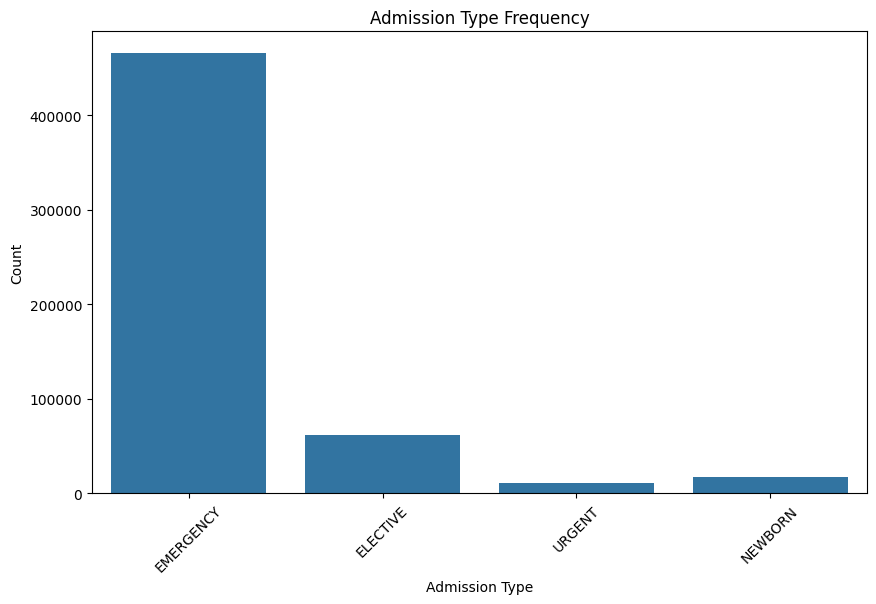

In [ ]:
print('\n---------Admission Type Statistics---------')
admission_type_counts = df_filter['ADMISSION_TYPE'].value_counts()
print(admission_type_counts)
print('\nTotal admissions recorded:', admission_type_counts.sum())

# bar plot for admission type
plt.figure(figsize=(10, 6))
sns.countplot(x='ADMISSION_TYPE', data=df_filter)
plt.title('Admission Type Frequency')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


---------Ethnicity Statistics---------
ETHNICITY
WHITE                                                       400708
BLACK/AFRICAN AMERICAN                                       55692
UNKNOWN/NOT SPECIFIED                                        29643
HISPANIC OR LATINO                                           13795
OTHER                                                        12638
UNABLE TO OBTAIN                                              9587
ASIAN                                                         7429
PATIENT DECLINED TO ANSWER                                    4603
HISPANIC/LATINO - PUERTO RICAN                                2998
ASIAN - CHINESE                                               2726
WHITE - RUSSIAN                                               2123
BLACK/CAPE VERDEAN                                            1749
MULTI RACE ETHNICITY                                          1122
BLACK/HAITIAN                                                 1104
ASIAN - ASIA

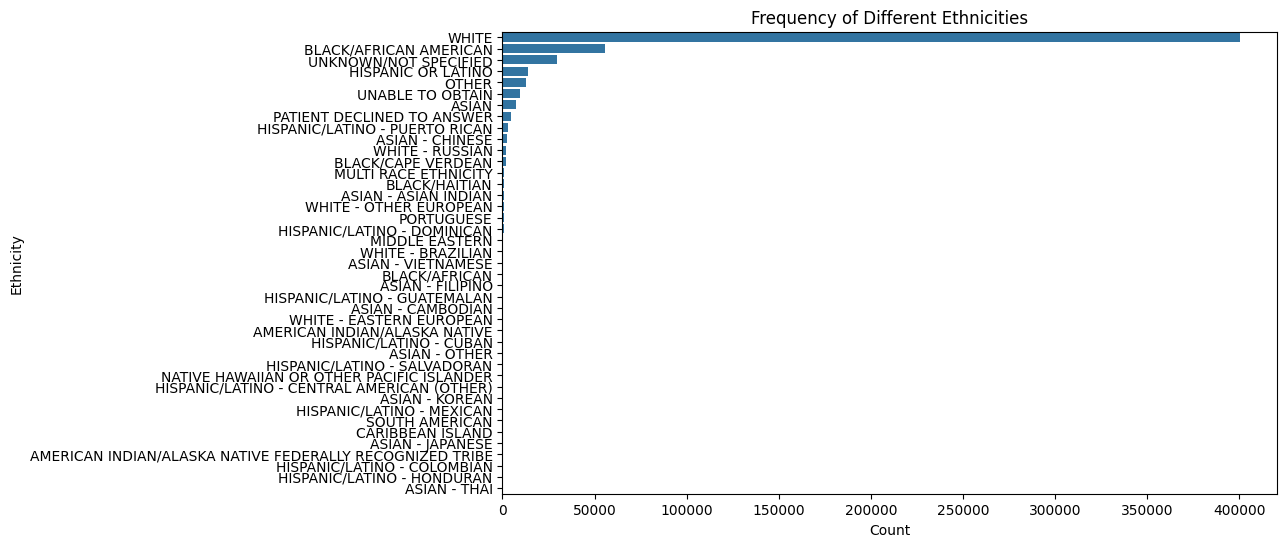

In [ ]:
# ethnicity statistics
print('\n---------Ethnicity Statistics---------')
ethnicity_counts = df_filter['ETHNICITY'].value_counts()
print(ethnicity_counts)
print('\nTotal ethnicity records:', ethnicity_counts.sum())

# count of different ethnicity
plt.figure(figsize=(10, 6))
sns.countplot(y='ETHNICITY', data=df_filter, order=df_filter['ETHNICITY'].value_counts().index)
plt.title('Frequency of Different Ethnicities')
plt.ylabel('Ethnicity')
plt.xlabel('Count')
plt.show()


---------Short Diagnoses Statistics---------
SHORT_TITLE
Hypertension NOS            16771
CHF NOS                     12418
Atrial fibrillation         11700
Crnry athrscl natve vssl    10003
Acute kidney failure NOS     8746
DMII wo cmp nt st uncntr     7997
Hyperlipidemia NEC/NOS       7789
Acute respiratry failure     7029
Urin tract infection NOS     6146
Esophageal reflux            5534
Anemia NOS                   4952
Pure hypercholesterolem      4511
Pneumonia, organism NOS      4495
Hypothyroidism NOS           4468
Acidosis                     4262
Ac posthemorrhag anemia      4109
Chr airway obstruct NEC      4101
Severe sepsis                3859
Long-term use anticoagul     3619
Septicemia NOS               3556
Name: count, dtype: int64

Total short diagnoses recorded in top 20: 136065


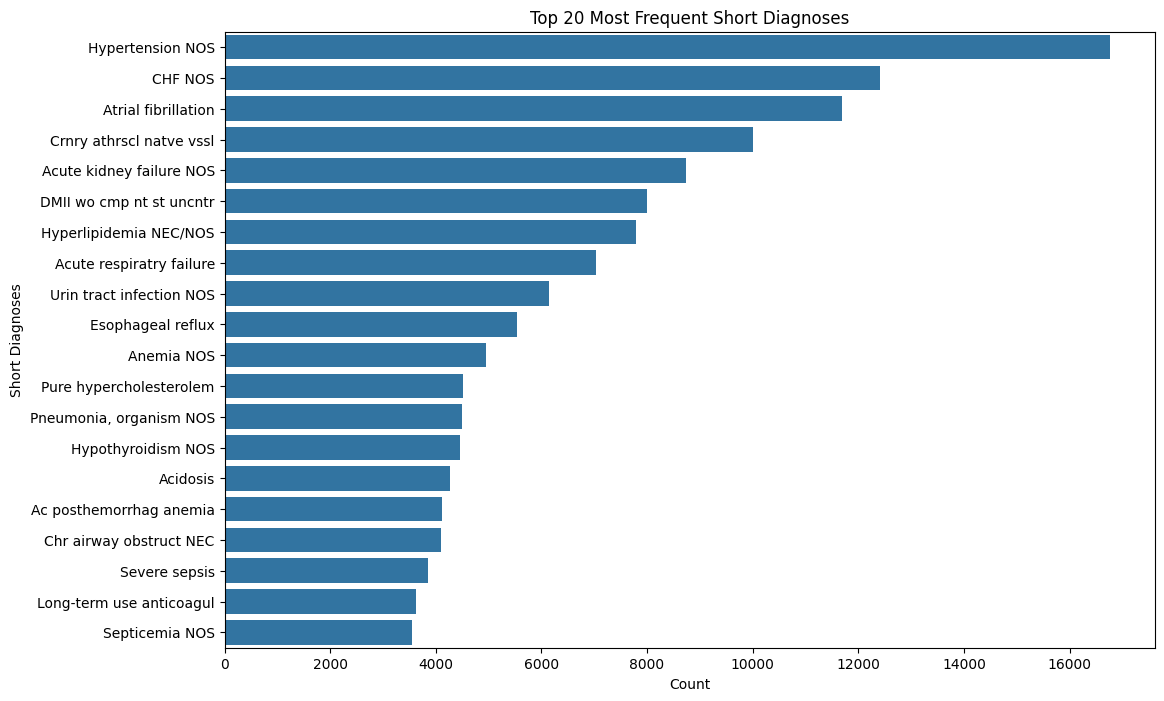

In [ ]:
# calculate top 20 for SHORT_TITLE
print('\n---------Short Diagnoses Statistics---------')
short_title_counts = df_filter['SHORT_TITLE'].value_counts().head(20)
print(short_title_counts)
print('\nTotal short diagnoses recorded in top 20:', short_title_counts.sum())

# plot for SHORT_TITLE
plt.figure(figsize=(12, 8))
sns.barplot(x=short_title_counts.values, y=short_title_counts.index)
plt.title('Top 20 Most Frequent Short Diagnoses')
plt.xlabel('Count')
plt.ylabel('Short Diagnoses')
plt.show()


---------Long Diagnoses Statistics---------
LONG_TITLE
Unspecified essential hypertension                                                                            16771
Congestive heart failure, unspecified                                                                         12418
Atrial fibrillation                                                                                           11700
Coronary atherosclerosis of native coronary artery                                                            10003
Acute kidney failure, unspecified                                                                              8746
Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled     7997
Other and unspecified hyperlipidemia                                                                           7789
Acute respiratory failure                                                                                      7029
Urinary tract in

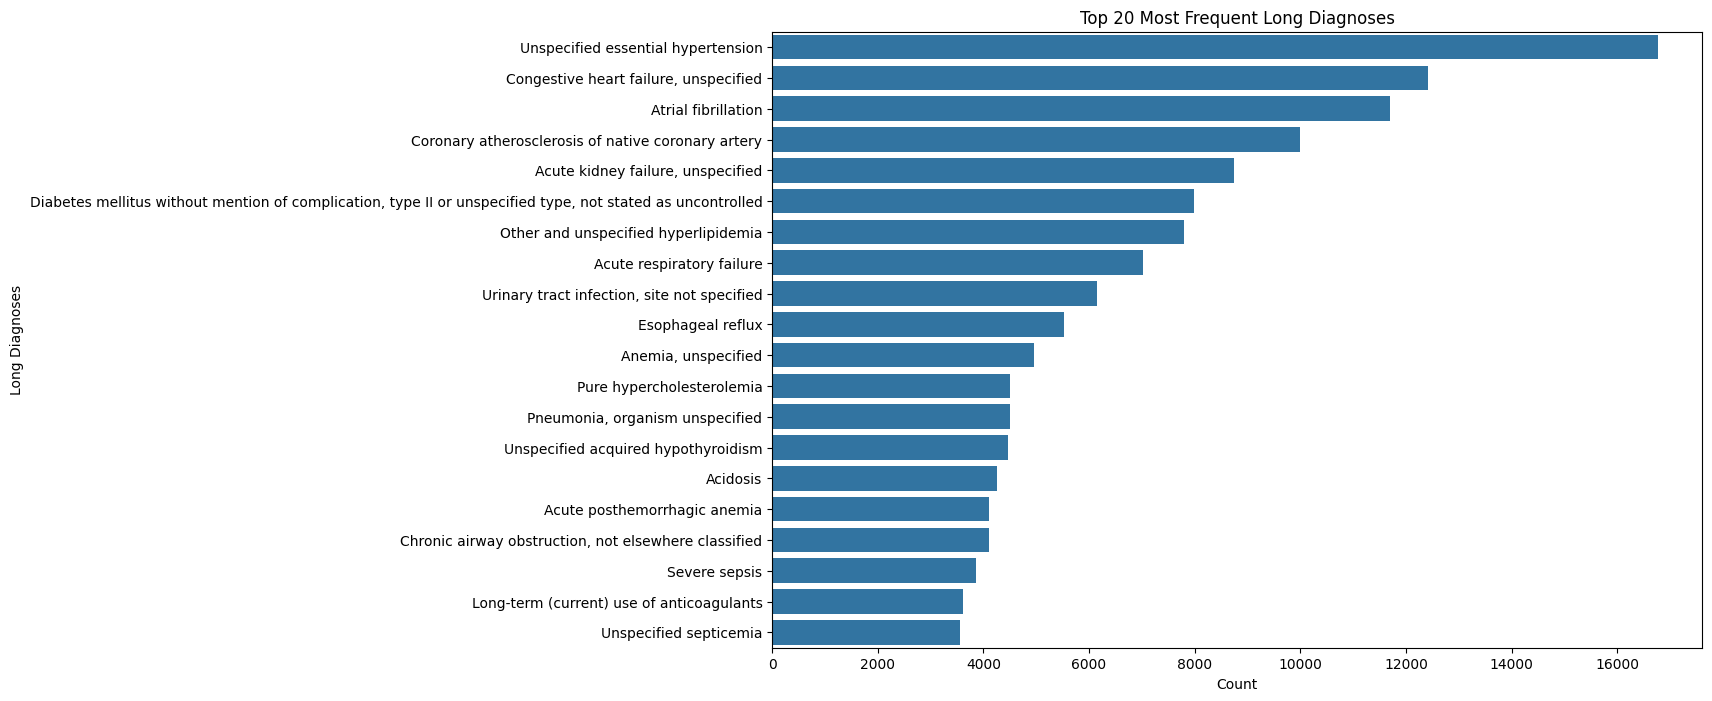

In [ ]:
# calculate top 20 for LONG_TITLE
print('\n---------Long Diagnoses Statistics---------')
long_title_counts = df_filter['LONG_TITLE'].value_counts().head(20)
print(long_title_counts)
print('\nTotal long diagnoses recorded in top 20:', long_title_counts.sum())

# plot for LONG_TITLE
plt.figure(figsize=(12, 8))
sns.barplot(x=long_title_counts.values, y=long_title_counts.index)
plt.title('Top 20 Most Frequent Long Diagnoses')
plt.xlabel('Count')
plt.ylabel('Long Diagnoses')
plt.show()


---------Age Group Distribution---------
AGE_GROUP
0-9       17946
10-19      1748
20-29     13461
30-39     20811
40-49     47207
50-59     87976
60-69    118546
70-79    119938
80-89     94832
90-99         0
Name: count, dtype: int64


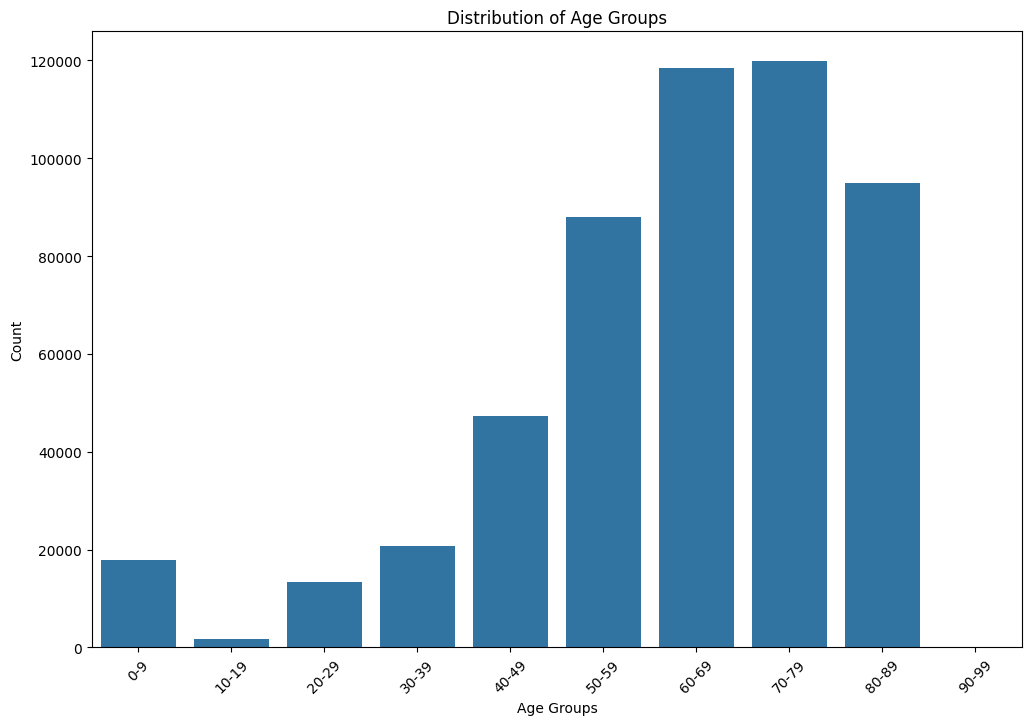

In [ ]:
# filter out row with age at admit greater than 100
df_filter = df_filter[df_filter['AGE_AT_ADMIT'] <= 100]

# create age bins
age_bins = [-1, 9, 19, 29, 39, 49, 59, 69, 79, 89, 99]
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99']

# create age group col
df_filter['AGE_GROUP'] = pd.cut(df_filter['AGE_AT_ADMIT'], bins=age_bins, labels=age_labels, right=True)

# count the number of patients in each age group
age_group_counts = df_filter['AGE_GROUP'].value_counts().sort_index()

# print out the result
print('\n---------Age Group Distribution---------')
print(age_group_counts)

# plotting the age group distribution
plt.figure(figsize=(12, 8))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


---------Top 5 Short Diagnoses by Age Group---------
AGE_GROUP                          
0-9        Neonat jaund preterm del    1399
           NB obsrv suspct infect      1205
           Need prphyl vc vrl hepat    1098
           Respiratory distress syn     944
           Primary apnea of newborn     838
10-19      Lung contusion-closed         38
           Traum pneumothorax-close      26
           Acute respiratry failure      23
           Alcohol abuse-unspec          20
           Loss control mv acc-driv      19
20-29      Acute respiratry failure     178
           Tobacco use disorder         144
           Acute kidney failure NOS     143
           Anemia NOS                   142
           Acidosis                     132
30-39      Hypertension NOS             319
           Acute respiratry failure     286
           Acute kidney failure NOS     269
           Anemia NOS                   205
           Depressive disorder NEC      204
40-49      Hypertension NOS   

C:\Users\ninep\AppData\Local\Temp\ipykernel_21876\3988954339.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_short_titles_by_age = df_filter.groupby('AGE_GROUP')['SHORT_TITLE'].apply(lambda x: x.value_counts().head(5))


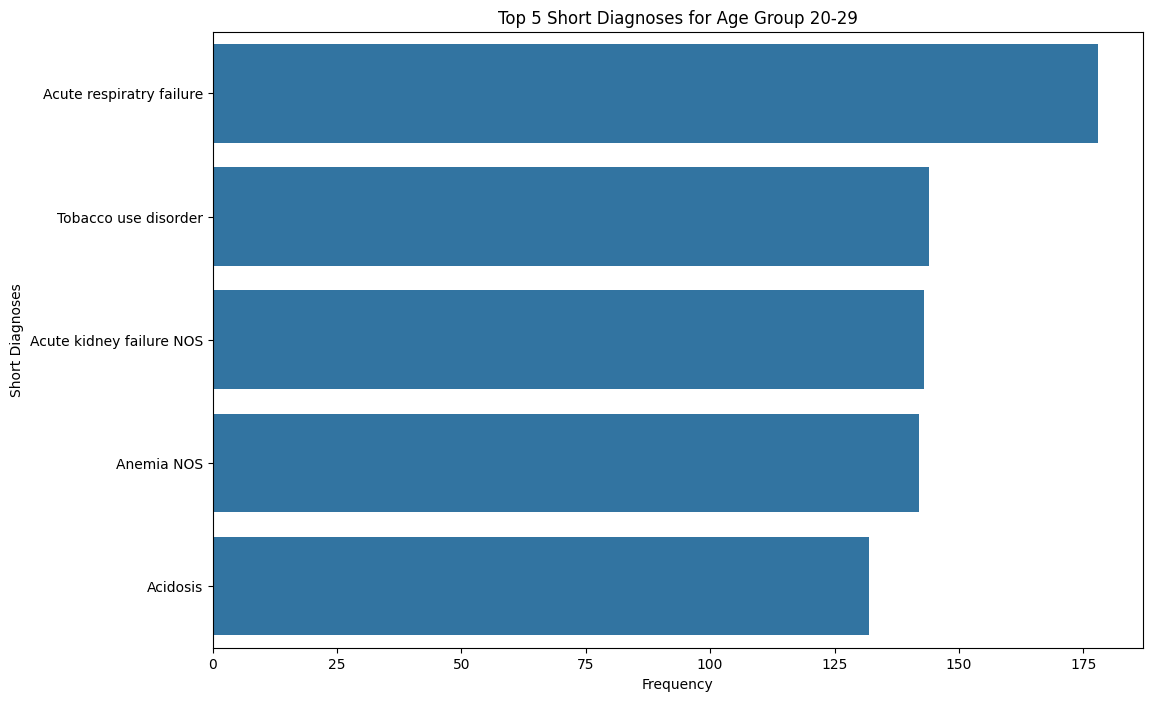

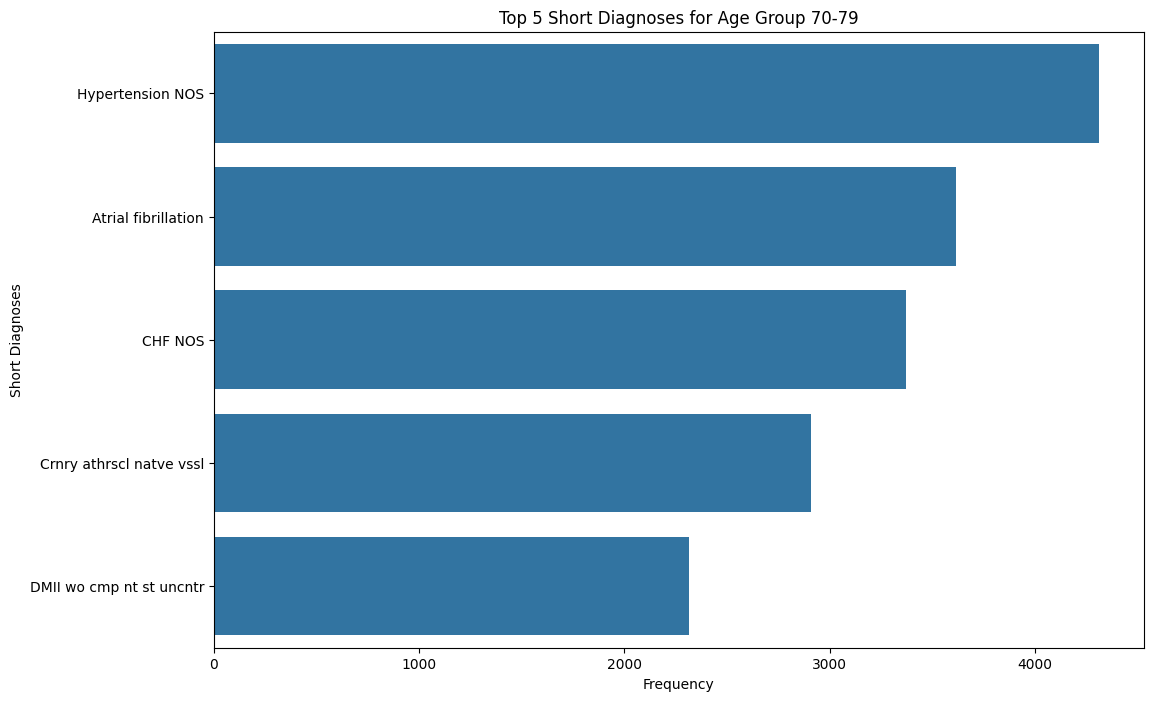

In [ ]:
# group by AGE_GROUP and get the top 5 SHORT_TITLE for each group
top_short_titles_by_age = df_filter.groupby('AGE_GROUP')['SHORT_TITLE'].apply(lambda x: x.value_counts().head(5))

print('\n---------Top 5 Short Diagnoses by Age Group---------')
print(top_short_titles_by_age)

# plotting the top 5 for Age_Group 20-29
plt.figure(figsize=(12, 8))
sns.barplot(x=top_short_titles_by_age['20-29'].values, y=top_short_titles_by_age['20-29'].index)
plt.title('Top 5 Short Diagnoses for Age Group 20-29')
plt.xlabel('Frequency')
plt.ylabel('Short Diagnoses')
plt.show();

# plotting the top 5 for Age_Group 70-79
plt.figure(figsize=(12, 8))
sns.barplot(x=top_short_titles_by_age['70-79'].values, y=top_short_titles_by_age['70-79'].index)
plt.title('Top 5 Short Diagnoses for Age Group 70-79')
plt.xlabel('Frequency')
plt.ylabel('Short Diagnoses')
plt.show();

In [ ]:
# group by AGE_GROUP and get the top 5 LONG_TITLE for each group
top_long_titles_by_age = df_filter.groupby('AGE_GROUP')['LONG_TITLE'].apply(lambda x: x.value_counts().head(5))

print('\n---------Top 5 Long Diagnoses by Age Group---------')
print(top_long_titles_by_age)


---------Top 5 Long Diagnoses by Age Group---------
AGE_GROUP                                                                                                                                                 
0-9        Neonatal jaundice associated with preterm delivery                                                                                                 1399
           Observation for suspected infectious condition                                                                                                     1205
           Need for prophylactic vaccination and inoculation against viral hepatitis                                                                          1098
           Respiratory distress syndrome in newborn                                                                                                            944
           Primary apnea of newborn                                                                                                         

C:\Users\ninep\AppData\Local\Temp\ipykernel_21876\423303892.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_long_titles_by_age = df_filter.groupby('AGE_GROUP')['LONG_TITLE'].apply(lambda x: x.value_counts().head(5))


In [ ]:
# group by SHORT_TITLE and extract the top 5 unique lengths of stay
mean_length_of_stay_by_short_title = df_filter.groupby('SHORT_TITLE')['LENGTH_OF_STAY'].mean().sort_values(ascending=False)
print('\n---------Top Diseases by Short Diagnoses with Highest Average Length of Stay---------')
print(mean_length_of_stay_by_short_title.head(10))

# group by LONG_TITLE and extract the top 5 unique lengths of stay
mean_length_of_stay_by_long_title = df_filter.groupby('LONG_TITLE')['LENGTH_OF_STAY'].mean().sort_values(ascending=False)
print('\n---------Top Diseases by Long Diagnoses with Highest Average Length of Stay---------')
print(mean_length_of_stay_by_long_title.head(10))


---------Top Diseases by Short Diagnoses with Highest Average Length of Stay---------
SHORT_TITLE
Cl skl w oth fx-mod coma    202.0
Fx legs w arm/rib-open      202.0
Human herpesvirus 6 infc    169.0
Adenoviral meningitis       169.0
Septic myocarditis          154.0
Chr mycot otitis externa    129.0
Nasal mucositis (ulcer)     119.0
Instantaneous death         119.0
Longitud defic radius       117.0
Human herpesvir 6 enceph    107.0
Name: LENGTH_OF_STAY, dtype: float64

---------Top Diseases by Long Diagnoses with Highest Average Length of Stay---------
LONG_TITLE
Open multiple fractures involving both lower limbs, lower with upper limb, and lower limb(s) with rib(s) and sternum                                                  202.0
Closed fractures involving skull or face with other bones with subarachnoid, subdural, and extradural hemorrhage, with moderate [1-24 hours] loss of consciousness    202.0
Meningitis due to adenovirus                                                       

In [ ]:
# count missing values in each column
missing_values = df_filter.isnull().sum()
print(missing_values[missing_values > 0])

DEATHTIME         454407
LANGUAGE          132688
RELIGION            1572
MARITAL_STATUS     35061
DIAGNOSIS             74
dtype: int64


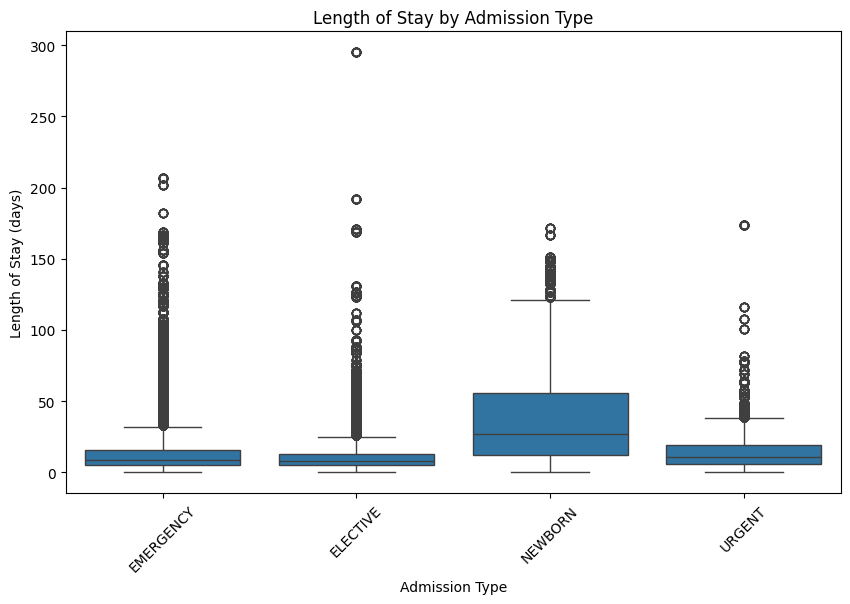

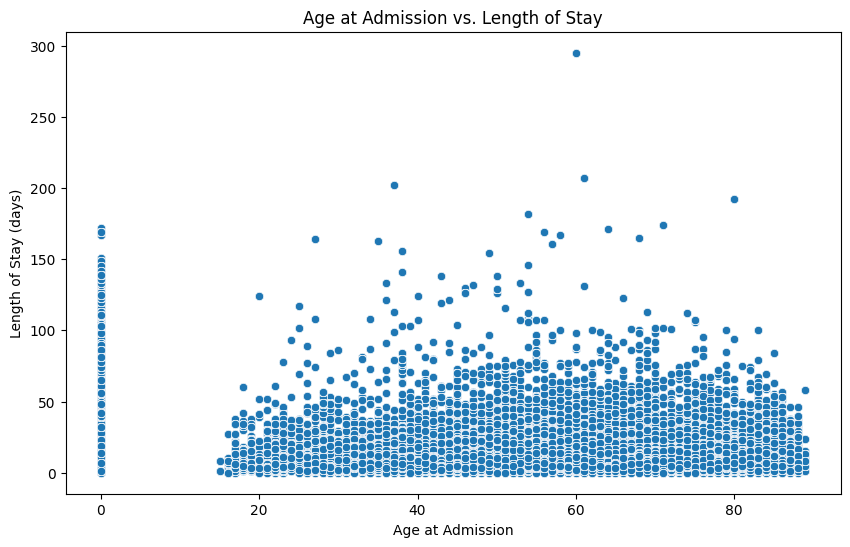

In [ ]:
# boxplot for length of stay by admission type
plt.figure(figsize=(10, 6))
sns.boxplot(x='ADMISSION_TYPE', y='LENGTH_OF_STAY', data=df_filter)
plt.title('Length of Stay by Admission Type')
plt.xlabel('Admission Type')
plt.ylabel('Length of Stay (days)')
plt.xticks(rotation=45)
plt.show()

# scatter plot of age vs. length of stay
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE_AT_ADMIT', y='LENGTH_OF_STAY', data=df_filter)
plt.title('Age at Admission vs. Length of Stay')
plt.xlabel('Age at Admission')
plt.ylabel('Length of Stay (days)')
plt.show()

**Exploratory Data Analysis (EDA) Findings**

Based on our exploratory data analysis, here are several key highlights from our observations:

* **Hypertension** is the most prevalent disease, followed by Congestive Heart Failure, unspecified (CHF NOS), and Atrial Fibrillation.
* The **emergency room** accounted for the majority of visits in the dataset, with over **40,000** visits.
* The predominant ethnicity in the dataset is **White**, comprising over **40,000** entries.
* The age group with the highest number of visits is **70-79**, totaling 119,938 visits, closely followed by the **60-69** age group with 118,546 visits.
* Individuals aged **30 to 79** primarily experience **Hypertension**, while those aged **80-89** predominantly visit for **Atrial Fibrillation**, more so than for Hypertension. The **20-29** age group primarily suffers from **Acute Respiratory Failure**.
* The **longest lengths of stay** are typically associated with severe conditions such as **Open Multiple Fractures** involving both lower limbs, combined with upper limb, and lower limb(s) with rib(s) and sternum, as well as **Closed Fractures** involving the skull or face with other bones, accompanied by subarachnoid, subdural, and extradural hemorrhage.
* The dataset contains outliers that are hard to identify, such as **ages over 100** and **missing values for 74 diagnoses**.

**Model Implementation**

Given the differences in data format between the MIMIC-III and CPRD databases, directly implementing the BEHRT model is not immediately feasible without a deeper understanding of these differences. As a result, we have tried to begin our exploration with a baseline model that uses LSTM layers combined with embedding, dense, and dropout layers. This approach allows us to establish a foundational model from which we can iteratively refine our analysis and adapt to the specifics of the MIMIC-III data.

BEHRT employs a multi-head self-attention mechanism that simultaneously learns relationships from different representation subspaces at different positions. This allows the model to focus on different parts of a patient's medical history for various types of predictions, such as the likelihood of future medical conditions. It also enables the model to make predictions while considering the entire context of the patient’s history, rather than just adjacent events.

The complexity of electronic health records, with their varying lengths and the nonlinear interactions between medical events, presents a significant challenge. BEHRT addresses this by using a bidirectional approach to learn from the entire sequence of a patient’s medical history. This way, the model captures the interdependencies not just based on the sequence of events but also considering the temporal gaps and the context of each event.

We have tried to build two LSTM models using two different approaches. First, we use all features from the previous visits. In this approach, we follow the core idea from the original paper by using the diagnoses from the previous 7 visits, including all columns, as features and the diagnosis from the 8 visit as the label. The second approach is more straightforward, we use only the diagnoses from the first 7 visits as features and the diagnosis from the 8 visit as the label to test how well each model performs.


**Model Training**

The training model utilizes a Long Short-Term Memory (LSTM) architecture, designed to handle the sequential nature of patient visit data encoded as numerical labels. Dropout layers with a rate of 0.2 are interspersed to mitigate overfitting. The model is compiled with the Adam optimizer and sparse categorical cross-entropy loss function, a common choice for multi-class classification tasks. It's trained over a course of 5 epochs with an added strategy for early stopping if the validation loss fails to improve for a series of iterations, thereby preventing unnecessary computations and potential overfitting. It is okay not to use high-performance GPU to run the model, given the dataset size and model logic in the current stage. Running it on using our PC's CPU is good enough.

In [ ]:
# label encoding
encoder = LabelEncoder()

# convert to numerical codes
df_filter['SHORT_TITLE'] = encoder.fit_transform(df_filter['SHORT_TITLE'])

# covert sequences of encoded
def prepare_sequences(group, max_len=7):

    # get sequences
    sequence = group['SHORT_TITLE'].values

    # generate input and label sequences
    X = [sequence[:i] for i in range(1, len(sequence))]
    y = sequence[1:]
    return pad_sequences(X, maxlen=max_len, padding='pre'), y

In [ ]:
# empty list for features and labels
X_list, y_list = [], []

# group by patients
grouped = df_filter.groupby('SUBJECT_ID').apply(lambda group: prepare_sequences(group, max_len=7))

# append sequences
for X, y in grouped:
    X_list.append(X)
    y_list.extend(y)

# combine into a single array
X = np.concatenate(X_list, axis=0)
y = np.array(y_list)

print(X.shape, y.shape)

(494028, 7) (494028,)


C:\Users\ninep\AppData\Local\Temp\ipykernel_21876\2623355123.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_filter.groupby('SUBJECT_ID').apply(lambda group: prepare_sequences(group, max_len=7))


In [ ]:
# number of classes
vocab_size = len(encoder.classes_)

# dimensionality of embedding layer
embed_dim = 64

# input sequences of visits
max_sequence_len = 7

# LSTM model
model = Sequential([Embedding(input_dim=vocab_size, output_dim=embed_dim),
                    LSTM(64, return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(vocab_size, activation='softmax')])

# compile the model using adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# build and summary of the model
model.build(input_shape=(None, 7))
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 7, 64)               │         412,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6443)                │         418,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 897,195 (3.42 MB)

 Trainable params: 897,195 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train and test split with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# check number of labels
num_classes = len(encoder.classes_)
print("Number of unique labels:", num_classes)

# example
print("Labels:", encoder.classes_)

Number of unique labels: 6443
Labels: ['"ventilation" pneumonit' '1st deg burn back' '1st deg burn leg-mult' ...
 'Wtrcraft fall NEC-pasngr' 'Zoonotic bact dis NOS' 'Zygomycosis']


In [ ]:
# apply early stopping and model checkpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
             ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)]

# training the model
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Epoch 1/5
3086/3088 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0355 - loss: 6.5508
Epoch 1: val_loss improved from inf to 5.85903, saving model to best_model.keras
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 48s 15ms/step - accuracy: 0.0355 - loss: 6.5505 - val_accuracy: 0.0562 - val_loss: 5.8590
Epoch 2/5
3085/3088 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0593 - loss: 5.8047
Epoch 2: val_loss improved from 5.85903 to 5.68277, saving model to best_model.keras
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.0593 - loss: 5.8047 - val_accuracy: 0.0752 - val_loss: 5.6828
Epoch 3/5
3084/3088 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0762 - loss: 5.6308
Epoch 3: val_loss improved from 5.68277 to 5.57710, saving model to best_model.keras
3088/3088 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - accuracy: 0.0762 - loss: 5.6308 - val_accuracy: 0.0844 - val_loss: 5.5771
Epoch 4/5
3085/3088 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0838 - loss: 5.5229
Epoch 4: val_loss improved from 5.

In [ ]:
# model evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

3088/3088 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.0938 - loss: 5.4772
Test Accuracy:  0.09363804012537003
Test Loss:  5.468618869781494


**Model Apparoch #2**

In [ ]:
# create sequences data
def seqeuences_data(df):
    if len(df) >= 8:
        # extract the first 7 visit as features
        features = df['SHORT_TITLE'].iloc[:7].tolist()

        # extract the 8th visit as label
        label = df['SHORT_TITLE'].iloc[7]
        return pd.Series([features, label], index=['Features', 'Label'])
    else:
        # return None if there are not enough visit
        return pd.Series([None, None], index=['Features', 'Label'])

# apply the seqeuences_data
df_2 = df_filter.groupby('SUBJECT_ID').apply(seqeuences_data).dropna().reset_index(drop=True)

C:\Users\ninep\AppData\Local\Temp\ipykernel_21876\1293630477.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_2 = df_filter.groupby('SUBJECT_ID').apply(seqeuences_data).dropna().reset_index(drop=True)


In [ ]:
# prepare data
X = df_2['Features'].tolist()
y = df_2['Label'].values

# train and test split with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# max 7 visits
max_len = 7

# padding the sequences and remove extra sequence at the end
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')


In [ ]:
# number of classes
vocab_size = len(encoder.classes_)

# another simple LSTM model
model = Sequential([Embedding(input_dim=vocab_size, output_dim=64),
                    LSTM(64, return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(vocab_size, activation='softmax')
                   ])

# compile the model using adam optimizer and sparse_categorical_crossentropy loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# build and summary of the model
model.build(input_shape=(None, max_len))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 7, 64)               │         412,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6443)                │         418,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 897,195 (3.42 MB)

 Trainable params: 897,195 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# check number of labels
num_classes = len(encoder.classes_)
print("Number of unique labels (classes):", num_classes)

# example of labels
print("Classes:", encoder.classes_)

Number of unique labels (classes): 6443
Classes: ['"ventilation" pneumonit' '1st deg burn back' '1st deg burn leg-mult' ...
 'Wtrcraft fall NEC-pasngr' 'Zoonotic bact dis NOS' 'Zygomycosis']


In [ ]:
# apply early stopping and model checkpoint
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1),
             ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)]

# training the model with 16 batch this time
history = model.fit(X_train_padded, y_train,
                    epochs=5,
                    batch_size=16,
                    validation_data=(X_test_padded, y_test),
                    callbacks=callbacks)


Epoch 1/5
1419/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0464 - loss: 6.9733
Epoch 1: val_loss improved from inf to 6.32669, saving model to best_model.keras
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.0464 - loss: 6.9722 - val_accuracy: 0.0573 - val_loss: 6.3267
Epoch 2/5
1418/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0628 - loss: 6.0676
Epoch 2: val_loss improved from 6.32669 to 6.11835, saving model to best_model.keras
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0628 - loss: 6.0674 - val_accuracy: 0.0652 - val_loss: 6.1184
Epoch 3/5
1420/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0694 - loss: 5.7643
Epoch 3: val_loss improved from 6.11835 to 6.08606, saving model to best_model.keras
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.0694 - loss: 5.7643 - val_accuracy: 0.0714 - val_loss: 6.0861
Epoch 4/5
1420/1422 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0815 - loss: 5.6211
Epoch 4: val_loss did not improve from 6.

In [ ]:
# model evaluation
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print("Test Accuracy: ", test_acc)
print("Test Loss: ", test_loss)

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0813 - loss: 6.1132
Test Accuracy:  0.08034458756446838
Test Loss:  6.11722993850708


**Model Results and Analysis**

Based on our comparison between two models, one using all features from the previous seven visits and another using only the diagnoses from the previous seven visits with over 5 epochs, we observed the following metrics and outcomes:

| Model         |Train Accuracy | Train Loss | Test Accuracy | Test Loss |
|---------------|----------|-----------|--------|-------|
| Model Approach 1   | 0.0891 | 5.4372 | 0.0936 | 5.4686 |
| Model Approach 2   | 0.0889 | 5.4796 | 0.0803 | 6.1172 |

It has been observed above that both models achieve similar results during the initial 5 epochs, making it too early to conclude which approach is better. We are considering combining the two approaches into a 3rd model to see if this integration enhances performance. However, due to time constraints, we plan to keep our experiments as straightforward as possible, limiting them to the initial 5 epochs.

As for **evaluation matrics**, Due to the extensive number of class labels, we have not yet fully evaluated the model using precision, recall, F1 score, and ROC AUC metrics. Moving forward, after significantly reducing the number of class labels, we plan to uses these metrics into our replication process to provide a more comprehensive assessment.

**Discussion and Plans: Moving Forward with Replication**

As we work on replicating the paper, the differences between the MIMIC-III and CPRD databases have showed significant challenges. We need to fully understand the format used in the original paper before we can effectively apply the BEHRT model to the MIMIC-III dataset.

Moving forward, we want to further refine our dataset, particularly by **reducing the number of class labels to 301 or less**, similar to the original study instead of the **over 5,000 and 6,000 labels** currently in use. In addition, we plan to revisit the paper and possibly improve our data cleaning process to ensure that our model replicates the original study as closely as possible.

Once we fully understand the BEHRT model with the CPRD dataset as described in the original paper, we may apply the same techniques to the MIMIC-III dataset and attempt to replicate the results. However, it is important to note that our model's performance may not match that of the original study, due to differences in data structure and volume.

**Dataset Resources**

* MIMIC-III Clinical Database (https://physionet.org/content/mimiciii/1.4/)

**Reference**

* Li, Y., Rao, S., Ayala Solares, J. R., Hassaine, A., Ramakrishnan, R., Canoy, D., Zhu, Y., Rahimi, K., & Salimi-Khorshidi, G. (2020). BEHRT: Transformer for Electronic Health Records. Scientific Reports, 10(7155). https://doi.org/10.1038/s41598-020-62922-y